In [24]:
import numpy as np
import os
from PIL import Image

# Importations pour la construiction du modèle
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.preprocessing import image

# Importation pour les visualisations
import matplotlib.pyplot as plt

from keras.saving import register_keras_serializable

# couche personnalisée pour gérer le pré-traitement des images 
@register_keras_serializable()   
class EfficientnetPreprocess(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EfficientnetPreprocess, self).__init__(**kwargs)
    def call(self, inputs):
        return tf.keras.applications.efficientnet.preprocess_input(inputs)
        
def grad_cam(image, model, layer):
    
    # Créer un modèle qui génère les sorties de la couche convolutive et les prédictions
    grad_model = Model(inputs=model.input, outputs=[layer.output, model.output])

    # Calcul des gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        #predicted_class = tf.argmax(predictions[0])  # Classe prédite
        predicted_class = tf.argmax(predictions[0]).numpy() # Classe prédite
        predicted_score = tf.reduce_max(predictions[0]).numpy()
        loss = predictions[:, predicted_class]  # Perte pour la classe prédite

    # Gradients des scores par rapport aux sorties de la couche convolutive
    grads = tape.gradient(loss, conv_outputs)

    # Moyenne pondérée des gradients pour chaque canal
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Pondération des activations par les gradients calculés
    conv_outputs = conv_outputs[0]  # Supprimer la dimension batch
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalisation de la carte de chaleur
    heatmap = tf.maximum(heatmap, 0)  # Se concentrer uniquement sur les valeurs positives
    heatmap /= tf.math.reduce_max(heatmap)  # Normaliser entre 0 et 1
    heatmap = heatmap.numpy()  # Convertir en tableau numpy pour la visualisation

   # Redimensionner la carte de chaleur pour correspondre à la taille de l'image d'origine
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (image.shape[1], image.shape[2])).numpy()
    heatmap_resized = np.squeeze(heatmap_resized, axis=-1) # supprimer la dimension de taille 1 à la fin du tableau heatmap_resized

    # Colorier la carte de chaleur avec une palette (par exemple, "jet")
    heatmap_colored = plt.cm.jet(heatmap_resized)[..., :3] # Récupérer les canaux R, G, B 

    superimposed_image = heatmap_colored * 0.7 + image[0] / 255.0

    # Convertir en NumPy array et supprimer la dimension batch
    #predictions_np = predictions.numpy().squeeze() 
    
    return np.clip(superimposed_image, 0, 1), predicted_class, predicted_score

def show_grad_cam_cnn(images, model):
    number_of_images = images.shape[0]
    # Récupérer les dernière couches convolutives
    conv_layers = [layer for layer in model.layers 
                   if isinstance(layer, Conv2D) and layer.name in  ["block7a_project_conv", "top_conv"] #(layer.name.startswith("top_") or layer.name.startswith("block7a_") or layer.name.startswith("block6a_"))
                  ]

    plt.figure(figsize=(16,16))

    for j, layer in enumerate(conv_layers):

        for i in range(number_of_images):

            subplot_index = i + 1 + j * number_of_images
            plt.subplot(len(conv_layers), number_of_images, subplot_index)
            # Obtenir l'image avec la carte de chaleur superposée 
            grad_cam_image, predicted_class, predicted_score = grad_cam(images[i], model, layer)
            
            # Afficher l'image avec Grad-CAM
            plt.title(f'Grad-CAM {layer.name}')
            plt.imshow(grad_cam_image)
            plt.axis("off")

    plt.show()

def load_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) # Ajout d'une dimension de batch
    x = preprocess_input(x)
    return x, img


categories = {
    10: "Livres occasion",
    2280: "Journaux et revues occasions",
    2403: "Livres, BD et magazines",
    2522: "Fournitures papeterie et accessoires bureau",
    2705: "Livres neufs",
    40: "Jeux videos, CDs, équipements, câbles, neufs",
    50: "Accessoires gaming",
    60: "Consoles de jeux",
    2462: "Jeux vidéos occasion",
    2905: "Jeux vidéos pour PC",
    1140: "Figurines, objets pop culture",
    1160: "Cartes de jeux",
    1180: "Figurines et jeux de rôles",
    1280: "Jouets enfant",
    1281: "Jeux société enfants",
    1300: "Modélisme",
    1302: "Jeux de pleins air, Habits",
    1560: "Mobilier général",
    2582: "Mobilier de jardin",
    1320: "Puériculture, accessoire bébé",
    2220: "Animalerie",
    2583: "Piscine et accessoires",
    2585: "Outillages de jardin, équipements extérieur et piscine",
    1920: "Linge de maison",
    2060: "Décoration",
    1301: "Chaussettes bébés, petites photos",
    1940: "Confiserie"
}



In [6]:
import tensorflow as tf
from keras.saving import register_keras_serializable

@register_keras_serializable()   
class EfficientnetPreprocess(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EfficientnetPreprocess, self).__init__(**kwargs)
    def call(self, inputs):
        return tf.keras.applications.efficientnet.preprocess_input(inputs)

# Chargement du model
model_loaded = tf.keras.models.load_model('../../reports/benchmark_images_models_results/EfficientNetB0_model_best.keras')

# Check
model_loaded.summary()



/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 448 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_3 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_3               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_3 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_3               │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet_preprocess_1       │ (None, 224, 224, 3)    │             0 │
│ (EfficientnetPreprocess)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 27)             │         3,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,420,544 (16.86 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,420,542 (16.86 MB)

 Optimizer params: 2 (12.00 B)

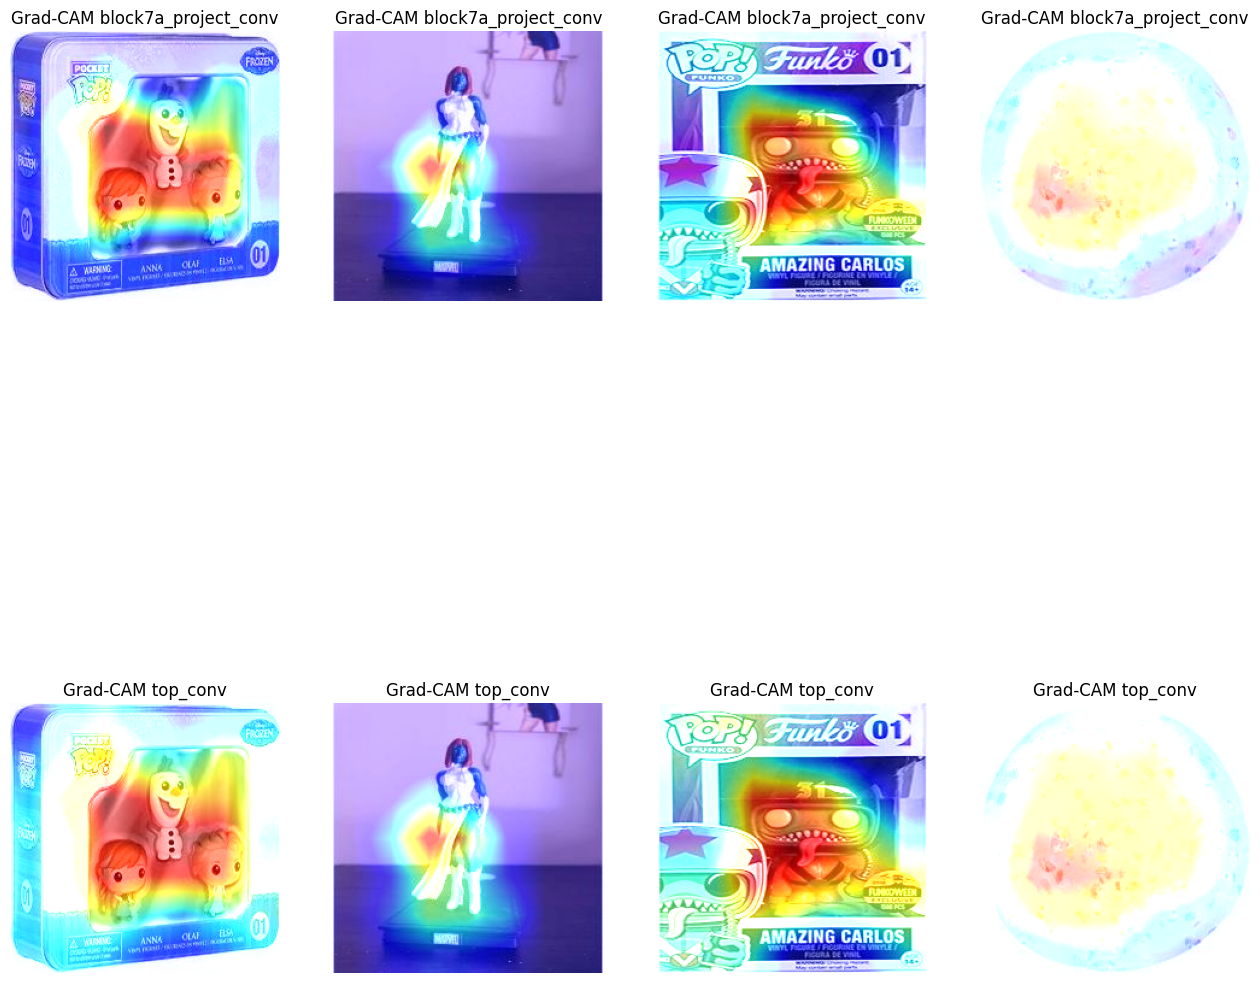

In [26]:
# Paramètres
dir_name = "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/sample_balanced" 
target_class = '1140'  # Nom de la classe que tu veux extraire
img_dir = os.path.join(dir_name, target_class)
img_size = (224, 224) # Taille cible

# Obtenir les 4 premiers fichiers image
img_files = sorted(os.listdir(img_dir))[:4]

# Charger et redimensionner les images
images = []
for file in img_files:
    img_path = os.path.join(img_dir, file)
    img_array, orig = load_image(img_path)
    images.append(img_array)

# Convertir en numpy array final
images = np.stack(images)

# Charger le modèle EfficientNetB0 pré-entraîné
model = EfficientNetB0(weights='imagenet')

show_grad_cam_cnn(images,model)